# Compare
### A notebook for exploring differences between the provided present and future scenario CESM simulations.
##### Initialized by Drew Camron 03/2018
---

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np
import xarray.ufuncs as xu

from pyresample import geometry, image

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='poster')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33617 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


Working directories for `pres_indir` and `fut_indir` datasets featuring *present-time* CESM simulations from Jen Kay **without** land/ocean 2CPC discrimination and `pres_lo_indir` and `fut_lo_indir` for the same **with** these discriminations, along with the CloudSat 2CPC gridded observations and CESM GIS mask file.

In [3]:
pres_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl/')
fut_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
             'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl/')

pres_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN/')
fut_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
            'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN/')

obs_indir = '/glade/p/work/jenkay/obs/COSP/CLOUDSAT/v2_Tristan/'

mask_indir = '/glade/p/work/lvank/racmo/gismask_RACMO23_0.9x1.25_con.nc'

Here I loop through the observation files to sort by year in `2006-2016` and the months within to read these files in chronologically.

In [4]:
obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [obs_indir+file for file in os.listdir(obs_indir) if mo+yr in file]

Now I open all of these datasets separately and establish usable pandas timedate indices and map the observation data to their lat-lon grids for easier analysis and plotting.

In [5]:
ds_pres = (xr.open_mfdataset(pres_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl.cam.h0.*.nc', decode_times=False)
          ).sel(lat=slice(0, 90))
ds_fut = (xr.open_mfdataset(fut_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl.cam.h0.*.nc', decode_times=False)
         ).sel(lat=slice(0, 90))

ds_lo_pres = (xr.open_mfdataset(pres_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
             ).sel(lat=slice(0, 90))
ds_lo_fut = (xr.open_mfdataset(fut_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
            ).sel(lat=slice(0, 90))

ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)

ds_pres['time'] = pd.date_range('2011-01', '2021-02', freq='MS')
ds_fut['time'] = pd.date_range('2081-01', '2090-12', freq='MS')
ds_lo_pres['time'] = pd.date_range('2011-01', '2025-12', freq='MS')
ds_lo_fut['time'] = pd.date_range('2081-01', '2095-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))

For my own reference, here is a list of the full names of variables in the CloudSat observations.

In [6]:
model_vars = ['RADAR_SNOWCERT', 'RADAR_SNOWPOSS', 'RADAR_RAINPROB']
obs_vars = ['snowcounts', 'snowpossiblecounts', 'probablecounts']

### `LANDOCN` data
Now I will begin the task of putting together my analysis of, first up, the `LANDOCN` data of Jen's featuring the land-ocean discriminations of 2CPC in her simulations.

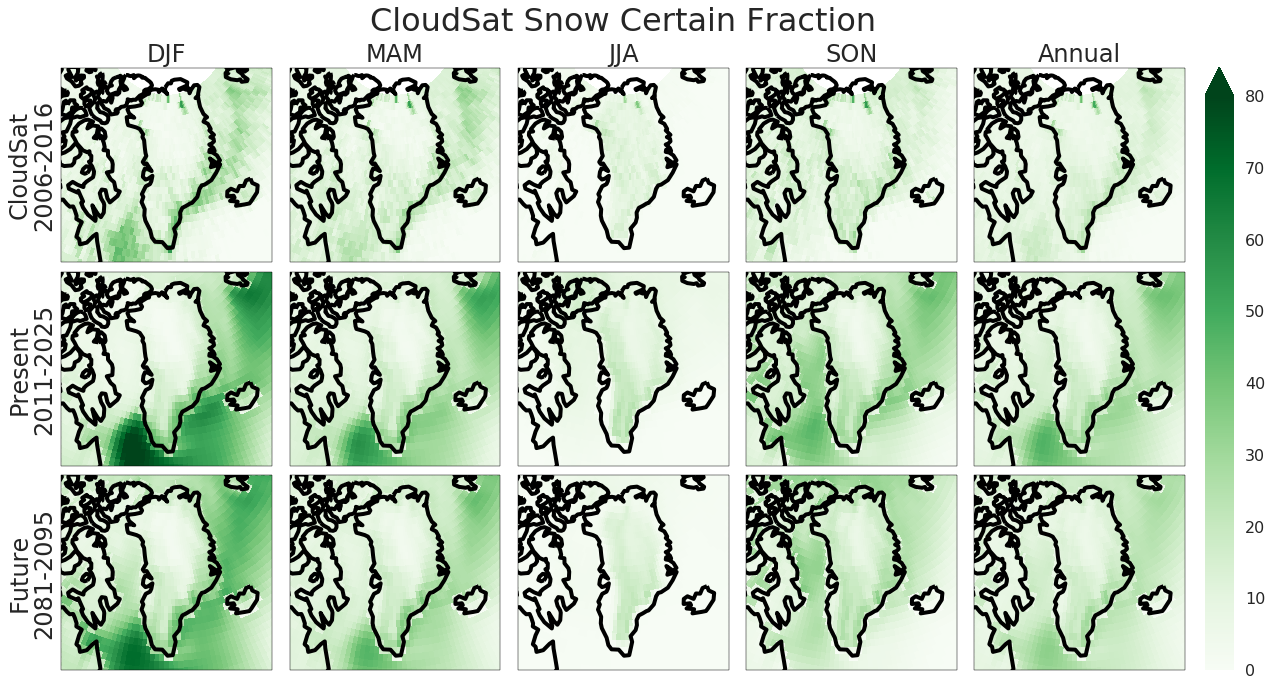

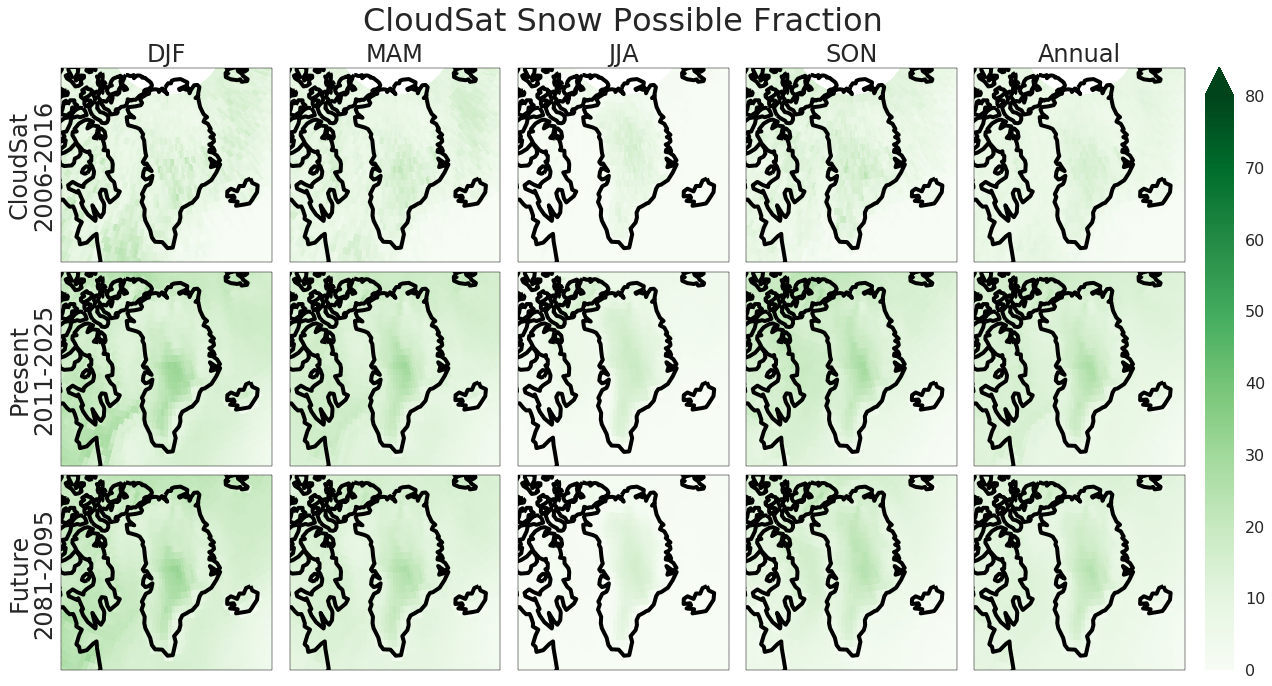

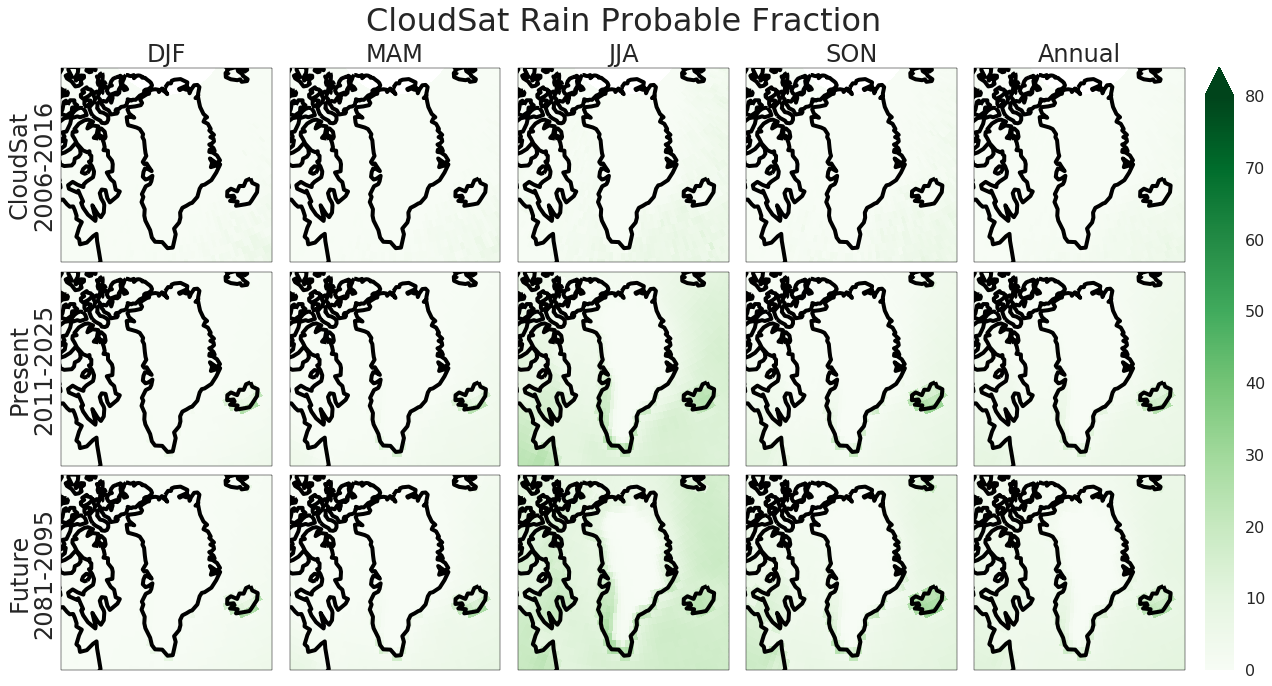

In [8]:
for n, var in enumerate(zip(model_vars, obs_vars)):
    
    f, axes = plt.subplots(
        nrows=3, ncols=5, figsize=(16, 9),
        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
    )
    
    
    for i, x in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ((ds_obs[var[1]] / ds_obs['counts'] * 100)
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[0, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=80, cmap='Greens'
         )
        )
        
        (ds_lo_pres[var[0]]
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[1, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=80, cmap='Greens'
         )
        )

        (ds_lo_fut[var[0]]
         .groupby('time.season')
         .mean('time')
         .sel(season=x)
         .plot.pcolormesh(
             ax=axes[2, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
             vmax=80, cmap='Greens'
         )
        )

        axes[0, i].set_title(x, fontsize=24)
        
        
    p = ((ds_obs[var[1]] / ds_obs['counts'] * 100)
         .mean('time')
         .plot.pcolormesh(
             ax=axes[0, 4], cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=80
         )
        )        

    (ds_lo_pres[var[0]]
     .mean('time')
     .plot.pcolormesh(
         ax=axes[1, 4], cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=80
     )
    )

    (ds_lo_fut[var[0]]
     .mean('time')
     .plot.pcolormesh(
         ax=axes[2, 4], cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=80
     )
    )

    
    axes[0, 4].set_title('Annual', fontsize=24)

    for ax in axes.flat:
        ax.coastlines(linewidth=4)
        ax.set_extent([290, 340, 55, 85])

    for ax, ylab, yr in zip(axes[:, 0], ['CloudSat', 'Present', 'Future'], ['2006-2016', '2011-2025', '2081-2095']):
        ax.text(-0.2, 0.5, ylab, rotation='vertical', fontsize=24,
                ha='center', va='center', transform=ax.transAxes)
        ax.text(-0.08, 0.5, yr, rotation='vertical', fontsize=24,
                ha='center', va='center', transform=ax.transAxes)

    t = f.suptitle(ds_lo_pres[var[0]].long_name, y=1.04, fontsize=32)    

    plt.tight_layout()

    #f.subplots_adjust(right=0.8, hspace=0.0000005, wspace=0.1)
    cb_ax = f.add_axes([1.005, 0.017, 0.025, 0.93])
    cb = f.colorbar(p, cax=cb_ax, extend='max')
    #cb.set_label('Percent of occurrence', rotation=270, fontsize=24)

    f.savefig('../figures/compare/map_grid_%s_LO.eps' % var[0],
              bbox_extra_artists=([t, cb_ax].append([ax for ax in axes[:, 0]])), bbox_inches='tight')

Now I want to cumbersomely create the above analysis, but for snow/rain fractions.

In [9]:
rain_pres = (
    ds_lo_pres['RADAR_RAINCERT'] + ds_lo_pres['RADAR_RAINHARD'] +
    ds_lo_pres['RADAR_RAINPOSS'] + ds_lo_pres['RADAR_RAINPROB'])# + 10**-16)
snow_pres = (
    ds_lo_pres['RADAR_SNOWCERT'] + ds_lo_pres['RADAR_SNOWPOSS'])# + 10**-16)

rain_fut = (
    ds_lo_fut['RADAR_RAINCERT'] + ds_lo_fut['RADAR_RAINHARD'] +
    ds_lo_fut['RADAR_RAINPOSS'] + ds_lo_fut['RADAR_RAINPROB'])# + 10**-16)
snow_fut = (
    ds_lo_fut['RADAR_SNOWCERT'] + ds_lo_fut['RADAR_SNOWPOSS'])# + 10**-16)

rain_obs = (
    ds_obs['raincounts'] + ds_obs['heavyraincounts'] +
    ds_obs['probablecounts'] + ds_obs['possiblecounts'])# + 10**-16)
snow_obs = (
    ds_obs['snowcounts'] + ds_obs['snowpossiblecounts'])# + 10**-16)

In [10]:
frac_pres = rain_pres / (snow_pres + 10**-16)
frac_fut = rain_fut / (snow_fut + 10**-16)
frac_obs = rain_obs / (snow_obs + 10**-16)

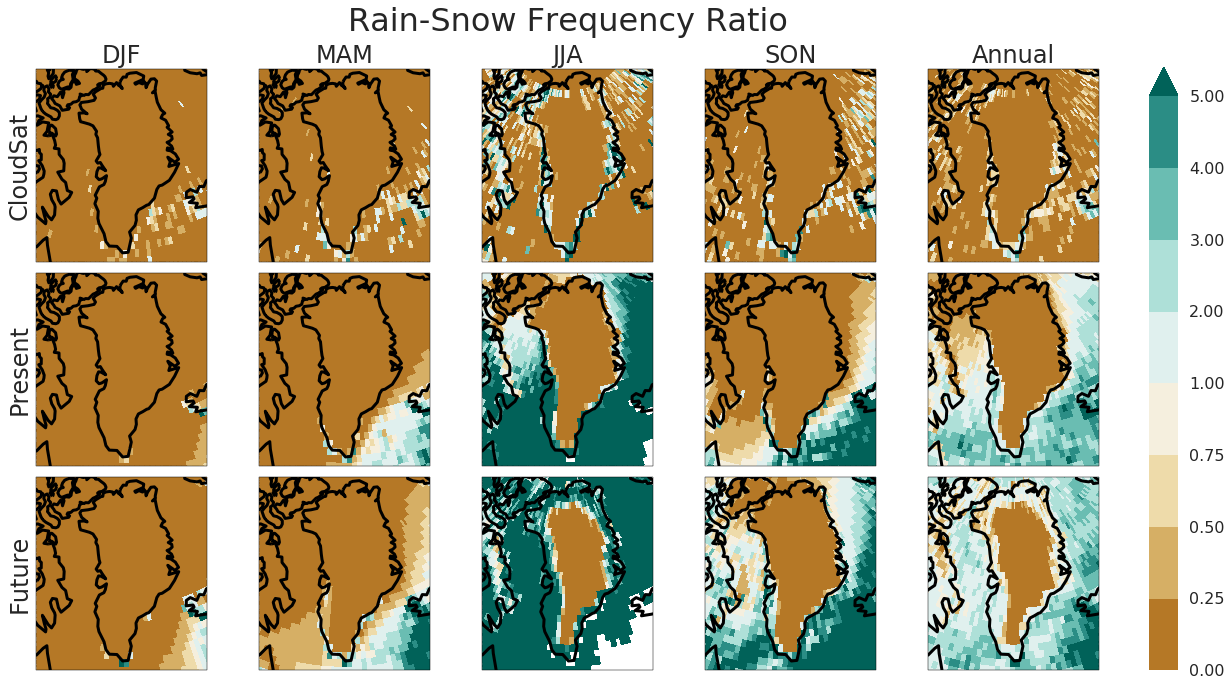

In [11]:
f, axes = plt.subplots(
    nrows=3, ncols=5, figsize=(16, 9),
    subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
)


for i, x in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    (frac_obs
     .where(frac_obs < 80)
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[0, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    (frac_pres
     .where(frac_pres < 80)
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[1, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    (frac_fut
     .where(frac_fut < 80)
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[2, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    axes[0, i].set_title(x, fontsize=24)
    

p = (frac_obs
     .where(frac_obs < 80)
     .mean('time', skipna=True)
     .plot.pcolormesh(
         ax=axes[0, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

(frac_pres
 .where(frac_pres < 80)
 .mean('time', skipna=True)
 .plot.pcolormesh(
     ax=axes[1, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
 )
)

(frac_fut
 .where(frac_fut < 80)
 .mean('time', skipna=True)
 .plot.pcolormesh(
     ax=axes[2, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
 )
)

axes[0, 4].set_title('Annual', fontsize=24)

for ax in axes.flat:
    ax.coastlines(linewidth=3)
    ax.set_extent([295, 335, 57, 84])


for ax, ylab in zip(axes[:, 0], ['CloudSat', 'Present', 'Future']):
    ax.text(-0.1, 0.5, ylab, rotation='vertical', fontsize=24,
            ha='center', va='center', transform=ax.transAxes)

t = f.suptitle('Rain-Snow Frequency Ratio', y=1.04, fontsize=32)    

plt.tight_layout()

#f.subplots_adjust(right=0.8, hspace=0.0000005, wspace=0.1)
cb_ax = f.add_axes([1.005, 0.017, 0.025, 0.93])
cb = f.colorbar(p, cax=cb_ax)#, extend='neither')
#cb.set_label('', rotation=270, fontsize=24)

f.savefig('../figures/compare/map_grid_rain-snow-frac_LO.eps',
         bbox_extra_artists=([t, cb_ax].append([ax for ax in axes[:, 0]])), bbox_inches='tight')

Here I will re-create my mean time series for certain outputs for these data. See `present` and `future` notebooks.

In [12]:
msi = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = msi.where(ms > 0)
w = np.tile((ds_lo_pres['gw'][0]*1.25/360), [len(ds_lo_pres['lon']), 1]).T

However, I need to interpolate my mask to the slightly different grid for the observations.

In [52]:
test = np.concatenate((msi.values[:, int(len(msi['lon']) / 2):], msi.values[:, 0:int(len(msi['lon']) / 2)]), axis=1)

(96, 288)

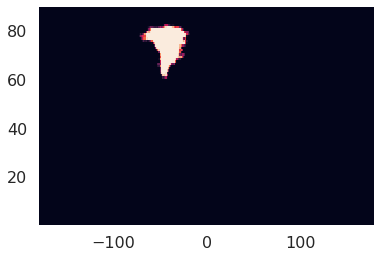

In [63]:
plt.pcolormesh(x, y, test)

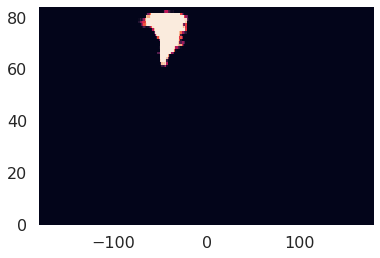

In [61]:
plt.pcolormesh(xx, yy, obs_ms)

In [54]:
x, y = np.meshgrid((msi['lon'].values - 180), msi['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

msi_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

msi_image = image.ImageContainerNearest(image_data=test, geo_def=msi_grid, radius_of_influence=100000)
obs_ms = msi_image.resample(obs_grid).image_data

In [56]:
w_image = image.ImageContainerNearest(image_data=w, geo_def=msi_grid, radius_of_influence=100000)
obs_w = w_image.resample(obs_grid).image_data

In [57]:
ds_lo_pres_w = (ds_lo_pres[[var for var in model_vars]] * ms.values * w).sum('lat').sum('lon') / 2
ds_lo_fut_w = (ds_lo_fut[[var for var in model_vars]] * ms.values * w).sum('lat').sum('lon') / 2
ds_obs_w = (ds_obs[[var for var in obs_vars]+['counts']] * 100 * obs_ms * obs_w).sum('latitude').sum('longitude') / 2

In [58]:
rain_pres_w = (rain_pres * ms.values * w).sum('lat').sum('lon') / 2
snow_pres_w = (snow_pres * ms.values * w).sum('lat').sum('lon') / 2

rain_fut_w = (rain_fut * ms.values * w).sum('lat').sum('lon') / 2
snow_fut_w = (snow_fut * ms.values * w).sum('lat').sum('lon') / 2

rain_obs_w = (rain_obs * obs_ms * obs_w).sum('latitude').sum('longitude') / 2
snow_obs_w = (snow_obs * obs_ms * obs_w).sum('latitude').sum('longitude') / 2

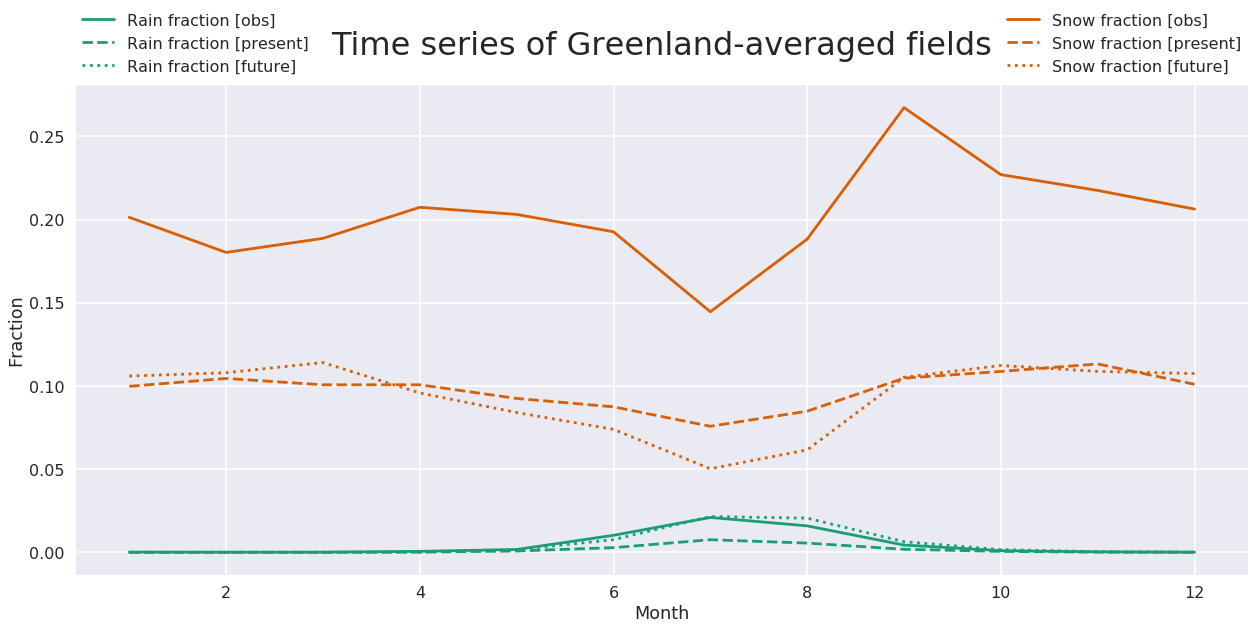

In [59]:
f, ax = plt.subplots(figsize=(21, 9))

((rain_obs_w / ds_obs_w['counts'] * 100)
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [obs]'),
      color=sns.color_palette('Dark2', 2)[0])
)

(rain_pres_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [present]'), linestyle='dashed',
       color=sns.color_palette('Dark2', 2)[0])
)

(rain_fut_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [future]'), linestyle='dotted',
       color=sns.color_palette('Dark2', 2)[0])
)

((snow_obs_w / ds_obs_w['counts'] * 100)
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [obs]'),
      color=sns.color_palette('Dark2', 2)[1])
)

(snow_pres_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [present]'), linestyle='dashed',
       color=sns.color_palette('Dark2', 2)[1])
)

(snow_fut_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [future]'), linestyle='dotted',
       color=sns.color_palette('Dark2', 2)[1])
)
    
ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Month')
ax.set_title('Time series of Greenland-averaged fields', y=1.05, fontsize=32)

f.savefig('../figures/compare/GIS-average_tseries_LO.eps', bbox_inches='tight')

### Non-`LANDOCN` data

Here I will make one meaningful figure to illustrate the differences in the `LANDOCN` discriminations.

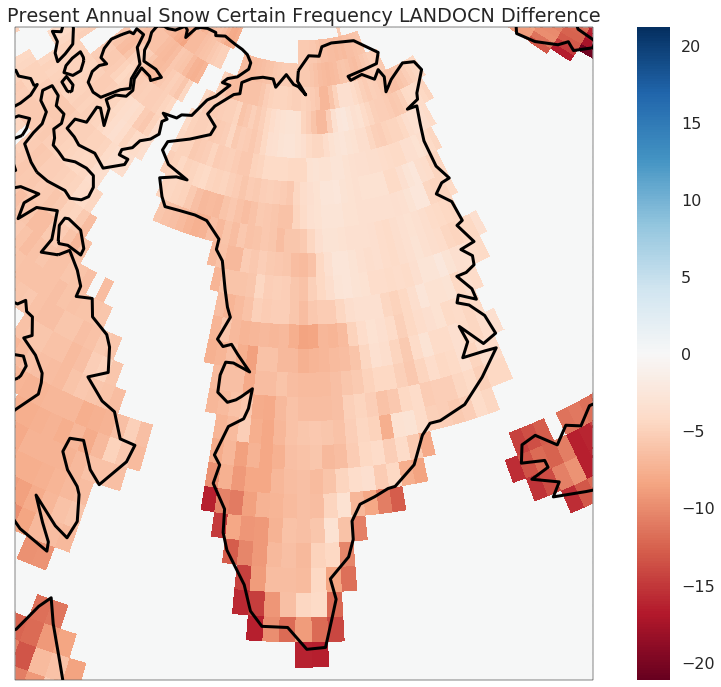

In [18]:
f, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

((ds_lo_pres['RADAR_SNOWCERT'] - ds_pres['RADAR_SNOWCERT'])
 #.groupby('time.season')
 .mean('time')
 #.sel(season='DJF')
 .plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_labels=False)
)

ax.coastlines(linewidth=3)
ax.set_extent([295, 335, 57, 84])

ax.set_title('Present Annual Snow Certain Frequency LANDOCN Difference')

f.savefig('../figures/compare/LO-difference-map.eps')